In [434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# apply some styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

In [435]:
weather_df = pd.read_csv('cleaned_weather.csv')
# read the solar plant generation data
solar_df = pd.read_csv('plant_output.csv')
# drop unused columns
solar_df = solar_df.drop(['Plant', 'Real-time power(kW)', 'Daily feed-in energy(kWh)', 'Energy purchased today(kWh)'], axis=1)

# Both weather and solar df are date aligned
data_df = weather_df
data_df['output'] = solar_df['Daily yield(kWh)']
# Remove entries with known 0 output
data_df = data_df[~(data_df['output'] == 0)]

In [412]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_cols = data_df.select_dtypes(include=[np.number]).columns
data_df = data_df[numeric_cols]
data_norm = pd.DataFrame(scaler.fit_transform(data_df))
data_norm.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.716355,-1.403946,-0.829721,-1.376138,0.242118,1.004365,-0.293308,-0.6003,-0.451987,-0.883851,-0.680943,-0.651917,-1.509529,-0.281256
1,-1.693505,-0.916350,-1.188969,-1.340224,-0.316047,0.483319,-0.293308,-0.6003,-0.451987,-0.686336,-0.583275,-0.588037,-1.502480,-0.042159
2,-1.670655,-1.322680,-1.787716,-1.735276,-1.127923,0.024799,-0.293308,-0.6003,-0.451987,0.044818,-0.513248,-0.502863,-1.495189,0.017616
3,-1.647804,-1.187236,-2.296651,-2.094413,-1.584603,-0.301724,-0.293308,-0.6003,-0.451987,-0.859595,-0.476393,-0.460277,-1.487654,-0.639903
4,-1.624954,-1.105970,-1.997277,-1.843017,-1.178665,-0.114147,-0.293308,-0.6003,-0.451987,-0.280909,-0.588803,-0.566744,-1.479148,-0.460580


In [ ]:
# Split data 
X = data_df.drop('output', axis=1)
y = data_df['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
print( 'X ', X.shape)
print( 'y ', y.shape)
print( 'X_train ', X_train.shape)
print( 'y_train ', y_train.shape)

In [415]:
def predict_and_eval(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    tr_mse = mean_squared_error(y_train, y_train_pred)
    tr_r2 = r2_score(y_train, y_train_pred)

    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"Train Mean Squared Error: {tr_mse}")
    print(f"Train R-squared: {tr_r2}")

    print(f"Test Mean Squared Error: {mse}")
    print(f"Test R-squared: {r2}")

    metrics = {
        'train_mse' : tr_mse,
        'train_r2' : tr_r2,
        'test_mse' : mse,
        'test_r2' : r2
        }

    return metrics, y_train_pred, y_test_pred

In [416]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError

In [429]:
def build_model():
    tf.random.set_seed(32)
    model = Sequential([
        Input(shape=(13,)),
        tf.keras.layers.Normalization(axis=None),
        #tf.keras.layers.Dropout(rate=0.1),
        Dense(units=128, activation='relu', name='layer0'),
        tf.keras.layers.Dropout(rate=0.1),
        Dense(units=64, activation='relu', name='layer1'),
        Dense(units=16, activation='relu', name='layer2'),
        Dense(units=1, activation='linear', name='output'),
        ])
    model.summary()
    return model

def train_model(model, X_train, y_train, epcs = 100):
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=MeanSquaredError())
    history = model.fit(X_train, y_train, epochs=epcs, verbose=0)
    nn_metrics, nn_y_train_pred, nn_y_test_pred = predict_and_eval(model, X_train, y_train, X_test, y_test)
    return nn_metrics, nn_y_test_pred


In [430]:
model = build_model()
max_iters = 10
for i in range (max_iters):
    #data_shuffled = data_df
    data_shuffled = data_df.sample(frac=1).reset_index(drop=True)
    X = data_shuffled.drop('output', axis=1)
    y = data_shuffled['output']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    nn_metrics, nn_y_test_pred = train_model(model, X_train, y_train, 50)
    print('==== Iter: ', i, nn_metrics, ' ====')
    if nn_metrics['test_r2'] > 0.7:
        break

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 13)             │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer0 (Dense)                  │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,108 (43.39 KB)

 Trainable params: 11,105 (43.38 KB)

 Non-trainable params: 3 (16.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Train Mean Squared Error: 13.071465278877458
Train R-squared: -0.07033401265628036
Test Mean Squared Error: 12.181212529231962
Test R-squared: -0.7266821505513508
==== Iter:  0 {'train_mse': 13.071465278877458, 'train_r2': -0.07033401265628036, 'test_mse': 12.181212529231962, 'test_r2': -0.7266821505513508}  ====
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Train Mean Squared Error: 5.541460863206323
Train R-squared: 0.5114767050820368
Test Mean Squared Error: 6.4176285799536785
Test R-squared: 0.3955744160578496
==== Iter:  1 {'train_mse': 5.541460863206323, 'train_r2': 0.5114767050820368, 'test_mse': 6.4176285799536785, 'test_r2': 0.3955744160578496}  ====
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Train Mean Squared Error: 3.613863866364928
Train R-squared: 0.6806910002855948
Test Mean Squared Error: 9.964590090524673
Test R-squared: 0.040785656

In [431]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 1.6148


1.6147758960723877

In [432]:
compare_df = pd.DataFrame(y_test)
compare_df['pred'] = nn_y_test_pred
compare_df.head(10)

,output,pred
40,11.3,11.258956
147,15.1,14.996629
38,14.0,12.206337
132,15.8,15.302635
144,8.4,10.092397
99,12.2,11.409852
83,13.6,13.647299
39,13.3,13.058636
136,11.6,11.840621
23,13.5,14.348142


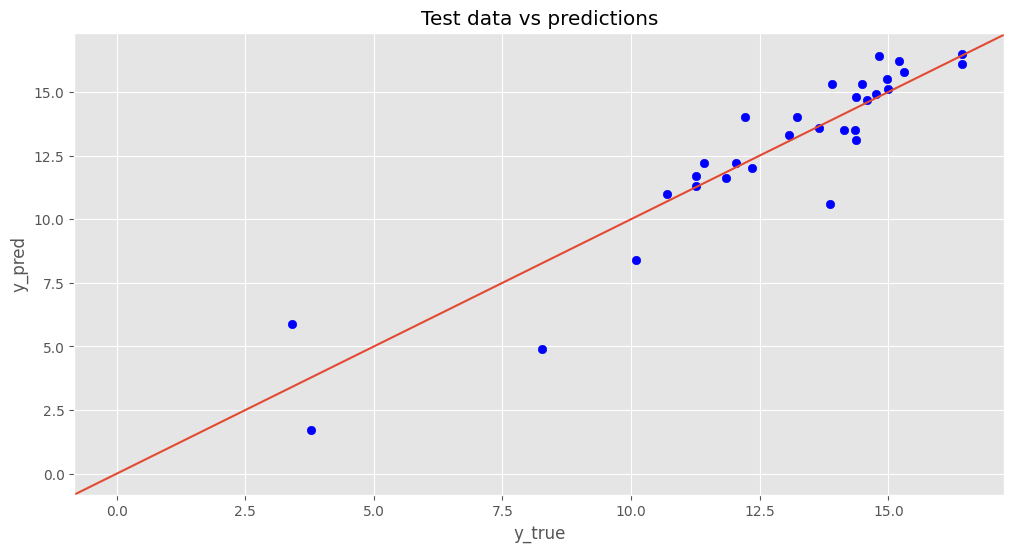

In [433]:
plt.scatter(nn_y_test_pred, y_test,c= 'blue')
ax = plt.subplot()
ax.axline((0, 0), slope=1)
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Test data vs predictions')
plt.show()

### Observations
1. Multiple training rounds help improve the accuracy
2. Shuffling the dataset also allow better learning - even with fewer epochs. In this case though, the test dataset is not entirely new to the model. 
3. A R2 scores of > 70% for both training and test dataset is acheived with this NN. The NN model shows better balance of accuracy compared to Ridge or LassoCV regression models
4. Best R2 score seen with NN model
```
Train Mean Squared Error: 2.874224244599256
Train R-squared: 0.7230831100524593
Test Mean Squared Error: 3.124005194617189
Test R-squared: 0.777090053517122
```
